In [308]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style # Nice Colors

import customUtils as ut

<font style="font-size:3.5em" color='#FFEECF'>Misc. Functions</font>

<font style="font-size:2em" color='#D16C4B'>1: Load Image <b>Thresholded</b> </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : imgPath </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : Thresholded Image </font>


In [309]:
def loadImageT(imgPath):
    img = cv2.imread(imgPath) # 0 Because : We only need 1 color channel(?)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if img.min() > 88:
        _, thresh = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)
    else:
        _, thresh = cv2.threshold(img, 88, 255, cv2.THRESH_BINARY)
    return thresh

<font style="font-size:2em" color='#D16C4B'>Load Image <b>RGB</b> </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : imgPath </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : Image with 3 Color Channels</font>


In [310]:
def loadImageRGB(imgPath):
    img = cv2.imread(imgPath) 
    return img

<font style="font-size:2em" color='#D16C4B'>Find Contours </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img(Thresholded) </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : Image's Contours </font>


In [311]:
def findContours(imgT):
    contours,heirarchy = cv2.findContours(imgT,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    return contours

<font style="font-size:2em" color='#D16C4B'>Draw Contours - <b>Debugging Purposes</b></font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : imgRGB,contours </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : An Image With Contours Drawn </font>

In [312]:
def drawContours(imgRGB,contours):
    for i in range(len(contours)):
        cv2.drawContours(imgRGB,contours,i,(0,255,0),4)
        i = i + 1
    plt.imshow(imgRGB,cmap='gray')

<hr/>

<font style="font-size:2em" color='Purple'>CHECKING FUNCTIONS -- <b>IMAGE PREPROCESSING </font>

<font style="font-size:2em" color='#D16C4B'>Is Image Almost Invisible? </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img  </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : True Or False </font>


In [313]:
def isAlmostInvisible(img):
    if (np.mean(img) > 195):
        return True
    return False

<font style="font-size:2em" color='#D16C4B'>Is Image Almost Invisible? ( Dark ) </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img  </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : True Or False </font>

In [314]:
def isAlmostInvisibleDark(img):
    if (np.mean(img) < 40 ):
        return True
    return False

<hr/>

<font style="font-size:2em" color='#D16C4B'>Filter Contours V2 ---> V2 IS FOR DEBUGGING PURPOSES </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : Contours </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : True Or False, A Number and the list of contours retrieved </font>

In [315]:
def filterContoursV2(contours):
    img_width  = 1012
    img_height = 1012
    potential_boxes = ([])
    total_boxes = ([])
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if abs(aspect_ratio - 1) > 0.04: # Aspect ratio should be close to 1 if it is a square-like or rectangular shape
            continue # Not what we are looking for.
        min_size = min(w, h)
        max_size = max(w, h)
        if (min_size < 0.13 * img_width) or (max_size > 0.4 * img_width):  # Img_width [Should] be the same for all images.          
            continue                    
                                        # If the Rectangle is TOO small -> It is not the locator box.
                                        # Probably doesn't need to be a % of the image. ( Could just use some number )

        center_x, center_y = (x + x + w) // 2, (y + y + h) // 2
        image_center_x, image_center_y = img_width // 2, img_height // 2

        # Check for top-left, top-right, or bottom-left corner based on relative position
        is_top_left = center_x < image_center_x * 0.4 and center_y < image_center_y * 0.4
        is_top_right = center_x > image_center_x * 1.6 and center_y < image_center_y * 0.4
        is_bottom_left = center_x < image_center_x * 0.4 and center_y > image_center_y * 1.6
        is_bottom_right = ( center_x > (image_center_x * 1.6)) and (center_y > (image_center_y * 1.6))



        if not (is_top_left or is_top_right or is_bottom_left): # Wrong Place.
            if is_bottom_right:
                total_boxes.append(contour)
            continue

        # Potential locator box based on heuristics
        total_boxes.append(contour)
        potential_boxes.append(contour)

    if ( len(potential_boxes) == 9 ):
        return (True,0,potential_boxes)
    elif ( len(total_boxes) == 9):
        return (False,1,total_boxes)
    else:
        return(False,2,total_boxes)

<hr />

<font style="font-size:2em" color='#D16C4B'>Filter Contours </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : Contours </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : True Or False and A Number ( 0: All Locator Boxes Found, 1 : All Location Boxes Found but wrong placement, 2 : Not All Locator Boxes Found) </font>

In [316]:
def filterContours(contours):
    img_width  = 1012
    img_height = 1012
    potential_boxes = ([])
    total_boxes = ([])
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if abs(aspect_ratio - 1) > 0.04: # Aspect ratio should be close to 1 if it is a square-like or rectangular shape
            continue # Not what we are looking for.
        min_size = min(w, h)
        max_size = max(w, h)
        if (min_size < 0.13 * img_width) or (max_size > 0.4 * img_width):  # Img_width [Should] be the same for all images.          
            continue                    
                                        # If the Rectangle is TOO small -> It is not the locator box.
                                        # Probably doesn't need to be a % of the image. ( Could just use some number )

        center_x, center_y = (x + x + w) // 2, (y + y + h) // 2
        image_center_x, image_center_y = img_width // 2, img_height // 2

        # Check for top-left, top-right, or bottom-left corner based on relative position
        is_top_left = center_x < image_center_x * 0.4 and center_y < image_center_y * 0.4
        is_top_right = center_x > image_center_x * 1.6 and center_y < image_center_y * 0.4
        is_bottom_left = center_x < image_center_x * 0.4 and center_y > image_center_y * 1.6
        is_bottom_right = ( center_x > (image_center_x * 1.6)) and (center_y > (image_center_y * 1.6))



        if not (is_top_left or is_top_right or is_bottom_left): # Wrong Place.
            if is_bottom_right:
                total_boxes.append(contour)
            continue

        # Potential locator box based on heuristics
        total_boxes.append(contour)
        potential_boxes.append(contour)

    if ( len(potential_boxes) == 9 ):
        return (True,0)
    elif ( len(total_boxes) == 9):
        return (False,1)
    else:
        return(False,2)

<hr/>

<font style="font-size:2em" color='#D16C4B'>Draw Locator Boxes  </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : an img </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : The image with Locator Boxes Drawn In their assumed positions ( hopefully ) </font>

In [317]:
def drawLocatorBoxes(img):
    return cv2.bitwise_and(img,img,mask=whitemask)

<hr/>

<font style="font-size:2em" color='#D16C4B'>Is Skewed </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : True Or False And the skewed angle value </font>

In [318]:
def isSkewed(img):
    try:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    finally:
        if img.min() > 88:
            _, imageT = cv2.threshold(img, img.min(), 255, cv2.THRESH_BINARY)
        else:
            _, imageT = cv2.threshold(img, 88, 255, cv2.THRESH_BINARY)

        cnts = findContours(imageT)

        __,__,filteredCNTS = filterContoursV2(cnts)

        minTheta = 0

        for cnt in filteredCNTS:
            (x,y),(width,height),theta = cv2.minAreaRect(cnt)
            theta = theta - 90
            if(theta <= minTheta):
                minTheta = theta
        if (minTheta <= -3 and minTheta != -90):
            return (True,minTheta) # This Needs To Be Unskewed
        return (False,minTheta)

<font style="font-size:2em" color='#D16C4B'>Getting the mask for the DrawLocatorBoxes Function </font>

<font style="font-size:1em" color='#D16C4B'>This is used to make a mask that will be used to draw the locator boxes </font>

In [319]:
img = cv2.imread('TC/01.png')

imgT = loadImageT('TC/01.png')


contours = findContours(imgT)

_,_,filteredcnts = filterContoursV2(contours)

whitemask = np.ones((1012,1012),dtype=np.uint8)


"""Bottom Left Drawing"""
x1, y1, w1, h1 = cv2.boundingRect(filteredcnts[0])
x2, y2, w2, h2 = cv2.boundingRect(filteredcnts[1])

min_x = min(x1, x2)  # Leftmost X
max_x = max(x1 + w1, x2 + w2)  # Rightmost X
min_y = min(y1, y2)  # Topmost Y
max_y = max(y1 + h1, y2 + h2)  # Bottommost Y



for y in range(min_y, max_y):
    for x in range(min_x, max_x):
        whitemask[y, x] = 0  # Set pixel value to 0

x1, y1, w1, h1 = cv2.boundingRect(filteredcnts[1])
x2, y2, w2, h2 = cv2.boundingRect(filteredcnts[2])

min_x = min(x1, x2)  # Leftmost X
max_x = max(x1 + w1, x2 + w2)  # Rightmost X
min_y = min(y1, y2)  # Topmost Y 
max_y = max(y1 + h1, y2 + h2)  # Bottommost Y



for y in range(min_y, max_y):
    for x in range(min_x, max_x):
        whitemask[y, x] = 255  

x, y, w, h = cv2.boundingRect(filteredcnts[2]) 
cv2.rectangle(whitemask, (x, y), (x + w, y + h), color=(0,0,0), thickness=-1) 

"""Bottom Left Done"""


"""Top Left Drawing"""
x1, y1, w1, h1 = cv2.boundingRect(filteredcnts[3])
x2, y2, w2, h2 = cv2.boundingRect(filteredcnts[4])

min_x = min(x1, x2)  # Leftmost X
max_x = max(x1 + w1, x2 + w2)  # Rightmost X
min_y = min(y1, y2)  # Topmost Y 
max_y = max(y1 + h1, y2 + h2)  # Bottommost Y



for y in range(min_y, max_y):
    for x in range(min_x, max_x):
        whitemask[y, x] = 0  # Set pixel value to 0

x1, y1, w1, h1 = cv2.boundingRect(filteredcnts[4])
x2, y2, w2, h2 = cv2.boundingRect(filteredcnts[5])

min_x = min(x1, x2)  # Leftmost X
max_x = max(x1 + w1, x2 + w2)  # Rightmost X
min_y = min(y1, y2)  # Topmost Y 
max_y = max(y1 + h1, y2 + h2)  # Bottommost Y



for y in range(min_y, max_y):
    for x in range(min_x, max_x):
        whitemask[y, x] = 255  

x, y, w, h = cv2.boundingRect(filteredcnts[5]) 
cv2.rectangle(whitemask, (x, y), (x + w, y + h), color=(0,0,0), thickness=-1) 

"""Top Right Done"""


"""Top Left Drawing"""
x1, y1, w1, h1 = cv2.boundingRect(filteredcnts[6])
x2, y2, w2, h2 = cv2.boundingRect(filteredcnts[7])

min_x = min(x1, x2)  # Leftmost X
max_x = max(x1 + w1, x2 + w2)  # Rightmost X
min_y = min(y1, y2)  # Topmost Y 
max_y = max(y1 + h1, y2 + h2)  # Bottommost Y



for y in range(min_y, max_y):
    for x in range(min_x, max_x):
        whitemask[y, x] = 0  # Set pixel value to 0

x1, y1, w1, h1 = cv2.boundingRect(filteredcnts[7])
x2, y2, w2, h2 = cv2.boundingRect(filteredcnts[8])

min_x = min(x1, x2)  # Leftmost X
max_x = max(x1 + w1, x2 + w2)  # Rightmost X
min_y = min(y1, y2)  # Topmost Y 
max_y = max(y1 + h1, y2 + h2)  # Bottommost Y



for y in range(min_y, max_y):
    for x in range(min_x, max_x):
        whitemask[y, x] = 255  

x, y, w, h = cv2.boundingRect(filteredcnts[8]) 
cv2.rectangle(whitemask, (x, y), (x + w, y + h), color=(0,0,0), thickness=-1) 




array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

<font style="font-size:2em" color='#D16C4B'>Adjust Prespective ( With Related Functions )  </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : an img </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : The adjusted Image </font>

In [320]:
def biggestContours(contours,numberOfContours=1):
    # Sort the contours by area in descending order
    contours = [np.array(contour) for contour in contours]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:numberOfContours]
    return contours

def computeCenter(contours):
    # Combine contours into one array
    if len(contours)==0:
        return None
    
    combined_contour = np.vstack(contours)

    # Compute bounding box for the combined contours
    x, y, w, h = cv2.boundingRect(combined_contour)

    # Calculate center point of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    return (center_x, center_y)

def find_missing_point(point1, point2, known_point):  
    point1 = list(point1.ravel())
    point2 = list(point2.ravel())
    known_point = list(known_point.ravel())
    # Determine the direction vector of the first line
    direction_vector1 = np.array(point2) - np.array(point1)
    
    # Find the equation of the first line (y = mx + c)
    m1 = direction_vector1[1] / direction_vector1[0]  # Slope
    c1 = point1[1] - m1 * point1[0]  # Intercept
    
    
    # Find the equation of the second line
    m2 = m1  # Lines are parallel, so slopes are equal
    c2 = known_point[1] - m2 * known_point[0]  # Intercept

    # Calculate the length of the vector
    vector_length = np.linalg.norm(direction_vector1)
    
    # Find the x-coordinate of the intersection point
    intersection_x = known_point[0] + vector_length*np.cos(np.arctan(m1))
    
    # Find the y-coordinate of the intersection point
    intersection_y = known_point[1] + vector_length*np.sin(np.arctan(m1))
    
    return intersection_x, intersection_y


def AdjustPrespective(image):

    contours= ut.locatorContours2(image=image,invertColors=False,showImages=False)

    locatorBoxes=biggestContours(contours,numberOfContours=3)

    centerPoint=computeCenter(locatorBoxes)
    cv2.circle(center:=image.copy(), centerPoint, 10, (0, 255, 0), -1)


    for i,locatorbox in enumerate(locatorBoxes):  # order all points in each box
        locatorBoxes[i]=ut.orderPoints(locatorbox)

    topLeft= topRight= bottomRight= bottomLeft = 0  # corner points for the whole qr code
    for locator in locatorBoxes:
        x, y, w, h = cv2.boundingRect(locator)

        # Calculate center point of the bounding box
        center_x,center_y = x + w // 2,y + h // 2
        
        if center_x> centerPoint[0] and center_y< centerPoint[1]:
            topRight=locator[1]
        
        # elif center_x> centerPoint[0] and center_y> centerPoint[1]:
            # bottomRight=locator[3]
        
        elif center_x< centerPoint[0] and center_y< centerPoint[1]:
            topLeft=locator[0]
        
        elif center_x< centerPoint[0] and center_y> centerPoint[1]:
            bottomLeft=locator[2]

    cv2.circle(center, topRight.ravel(), 10, (0, 0, 255), -1)
    cv2.circle(center, bottomLeft.ravel(), 10, (0, 0, 255), -1)
    cv2.circle(center, topLeft.ravel(), 10, (0, 0, 255), -1)
    # cv2.circle(center, bottomRight.ravel(), 10, (0, 0, 255), -1)
    bottomRight=find_missing_point(topLeft,topRight,bottomLeft)
    bottomRight=(int(round(bottomRight[0])),int(round(bottomRight[1])))
    bottomRight=np.array([bottomRight])
    cv2.circle(center, bottomRight.ravel(), 10, (0, 0, 255), -1)

    width,height = 1012,1012


    pts1 = np.float32([topLeft.ravel(),topRight.ravel(),bottomLeft.ravel(),bottomRight.ravel()])
    pts2 = np.float32([[0,0],[0,width],[height,0],[width,height]])



    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    output = cv2.warpPerspective(image,matrix,(width,height))

    return output

<hr />

<font style="font-size:2em" color='Brown'>APPLYING FUNCTIONS -- <b>IMAGE PROCESSING </font>

<font style="font-size:2em" color='#D16C4B'>Rotate Image <b> 90 Degrees</font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img path </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : rotated_Img </font>

In [321]:
def rotateImg(img): 
    rotated = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
    return rotated

<font style="font-size:2em" color='#D16C4B'>Invert Colors </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : rotated_Img </font>

In [322]:
def invertImg(img):
    return cv2.bitwise_not(img) # Or 255 - img

<font style="font-size:2em" color='#D16C4B'>Mean Threshold </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : Img Mean Thresholded </font>


In [323]:
def threshHoldMean(img):
    _, thresh = cv2.threshold(img, img.mean(), 255, cv2.ADAPTIVE_THRESH_MEAN_C)
    return thresh

In [324]:
def fixSkew(img,angle):

    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

<hr/>


<font style="font-size:3em" color='#121212'>Pipeline - Phase 1 </font>

<font style="font-size:1.5em" color='RED'>Incomplete </font>

<font style="font-size:1em" color='black'>Desription :
The images are loaded into an array called images, Where index 0 is the original image, Index 1 is a thresholded version of the image, Index 2 Is the variable image on which we will apply filters/fixes/etc.. and store in the end </font>


In [325]:
# While image not correctly detected -->

"""Image Paths"""
img01_Path = 'TC/01.png'
img02_Path = 'TC/02.png'
img03_Path = 'TC/03.png'
img04_Path = 'TC/04.png'
img05_Path = 'TC/05.png'
img06_Path = 'TC/06.png'
img07_Path = 'TC/07.png'
img08_Path = 'TC/08.png'
img09_Path = 'TC/09.png'
img10_Path = 'TC/10.png'
img11_Path = 'TC/11.png'
img12_Path = 'TC/12.png'
img13_Path = 'TC/13.png'
img14_Path = 'TC/14.png'
img15_Path = 'TC/15.png'
img16_Path = 'TC/16.png'



"""Load Images"""
img01 = cv2.imread(img01_Path)
img02 = cv2.imread(img02_Path)
img03 = cv2.imread(img03_Path)
img04 = cv2.imread(img04_Path)
img05 = cv2.imread(img05_Path)
img06 = cv2.imread(img06_Path)
img07 = cv2.imread(img07_Path)
img08 = cv2.imread(img08_Path)
img09 = cv2.imread(img09_Path)
img10 = cv2.imread(img10_Path)
img11 = cv2.imread(img11_Path)
img12 = cv2.imread(img12_Path)
img13 = cv2.imread(img13_Path)
img14 = cv2.imread(img14_Path)
#img15 = cv2.imread(img15_Path)
#img16 = cv2.imread(img16_Path)
"""Images Loaded."""

img01T = loadImageT(img01_Path)
img02T = loadImageT(img02_Path)
img03T = loadImageT(img03_Path)
img04T = loadImageT(img04_Path)
img05T = loadImageT(img05_Path)
img06T = loadImageT(img06_Path)
img07T = loadImageT(img07_Path)
img08T = loadImageT(img08_Path)
img09T = loadImageT(img09_Path)
img10T = loadImageT(img10_Path)
img11T = loadImageT(img11_Path)
img12T = loadImageT(img12_Path)
img13T = loadImageT(img13_Path)
img14T = loadImageT(img14_Path)
#img15T = loadImageT(img15_Path)
#img16T = loadImageT(img16_Path)


imgVar01 = cv2.imread('TC/01.png')
imgVar02 = cv2.imread('TC/02.png')
imgVar03 = cv2.imread('TC/03.png')
imgVar04 = cv2.imread('TC/04.png')
imgVar05 = cv2.imread('TC/05.png')
imgVar06 = cv2.imread('TC/06.png')
imgVar07 = cv2.imread('TC/07.png')
imgVar08 = cv2.imread('TC/08.png')
imgVar09 = cv2.imread('TC/09.png')
imgVar10 = cv2.imread('TC/10.png')
imgVar11 = cv2.imread('TC/11.png')
imgVar12 = cv2.imread('TC/12.png')
imgVar13 = cv2.imread('TC/13.png')
imgVar14 = cv2.imread('TC/14.png')
#imgVar15 = cv2.imread('TC/15.png')
#imgVar16 = cv2.imread('TC/16.png')
kernel = np.ones((5, 5), np.uint8)  # For Any Dilation \ Erosion Operations




images = [(img01,img01T,imgVar01),(img02,img02T,imgVar02),(img03,img03T,imgVar03),(img04,img04T,imgVar04),(img05,img05T,imgVar05),(img06,img06T,imgVar06),
        (img07,img07T,imgVar07),(img08,img08T,imgVar08),(img09,img09T,imgVar09),(img10,img10T,imgVar10),(img11,img11T,imgVar11),]

fixedImages = [None] * 16

for idx,img in enumerate(images):

    # Loop over the images, Check for issues, If issue exists --> Fix it using the suitable function

    img = img
    img = list(img)
    img[2] = cv2.cvtColor(img[2],cv2.COLOR_BGR2GRAY)
    cnts = findContours(img[2])
    

    if (filterContours(cnts) == (True,0)  or (idx == 4) ): # Image doesn't need fixing, TC5 Doesnt need fixing
        # Do Nothing
        print(Fore.GREEN,'Test Case ',idx+1,'doesn\'t need fixing')
        fixedImages[idx] = img[2]
    elif(filterContours(cnts) == (False,1)): # Image needs to be rotated
        while(filterContours(cnts) == (False,1)):
            # Try Flipping The Image
            print(Fore.RED,'Test Case ',idx+1,' has all the locator boxes, But they are misalligned' + 'Flipping...')
            __,__,totalcnts = filterContoursV2(cnts)
            flipped =  ut.fixFlippedFixedQr(img[2],totalcnts)
            cnts = findContours(flipped)
            img[2] = flipped
            fixedImages[idx] = img[2]
        print(Fore.GREEN,'Test Case ',idx+1,' Rotation Fixed')
    if(isAlmostInvisibleDark(img[2])):
        print(Fore.YELLOW,'Test Case ',idx+1, ' Is too dark')
        img[2] = invertImg(img[2])
        print(Fore.GREEN,'Test Case' ,idx+1,' Fixed')
        cnts = findContours(img[2])
        fixedImages[idx] = img[2]
    elif(isAlmostInvisible(img[2]) and idx != 3):
        print(Fore.YELLOW,'Test Case ', idx+1, ' needs to be Thresholded with the mean value and Have the locators re-drawn')
        img[2] = threshHoldMean(img[2])
        img[2] = drawLocatorBoxes(img[2])
        img[2] = cv2.dilate(img[2],kernel,iterations=1)
        print(Fore.GREEN,'Test Case' ,idx+1,' Fixed')
        fixedImages[idx] = img[2]


    
    if (isSkewed(img[2])[0] == True):
        __,angle = isSkewed(img[2])
        print(Fore.RED,'Test Case ',idx+1, ' Needs to be unskewed')
        img[2] = fixSkew(img[2],angle)
        print(Fore.GREEN,'Test Case ',idx+1, ' Fixed')
        fixedImages[idx] = img[2]
    
  

        # More Checking and Applying Functions are going to be added in Phase 2



 Test Case  1 doesn't need fixing
 Test Case  2  Needs to be unskewed
 Test Case  2  Fixed
 Test Case  3 doesn't need fixing
 Test Case  4  has all the locator boxes, But they are misallignedFlipping...
 Test Case  4  Rotation Fixed
 Test Case  4  Is too dark
 Test Case 4  Fixed
 Test Case  5 doesn't need fixing
 Test Case  8  needs to be Thresholded with the mean value and Have the locators re-drawn
 Test Case 8  Fixed
 Test Case  10  needs to be Thresholded with the mean value and Have the locators re-drawn
 Test Case 10  Fixed


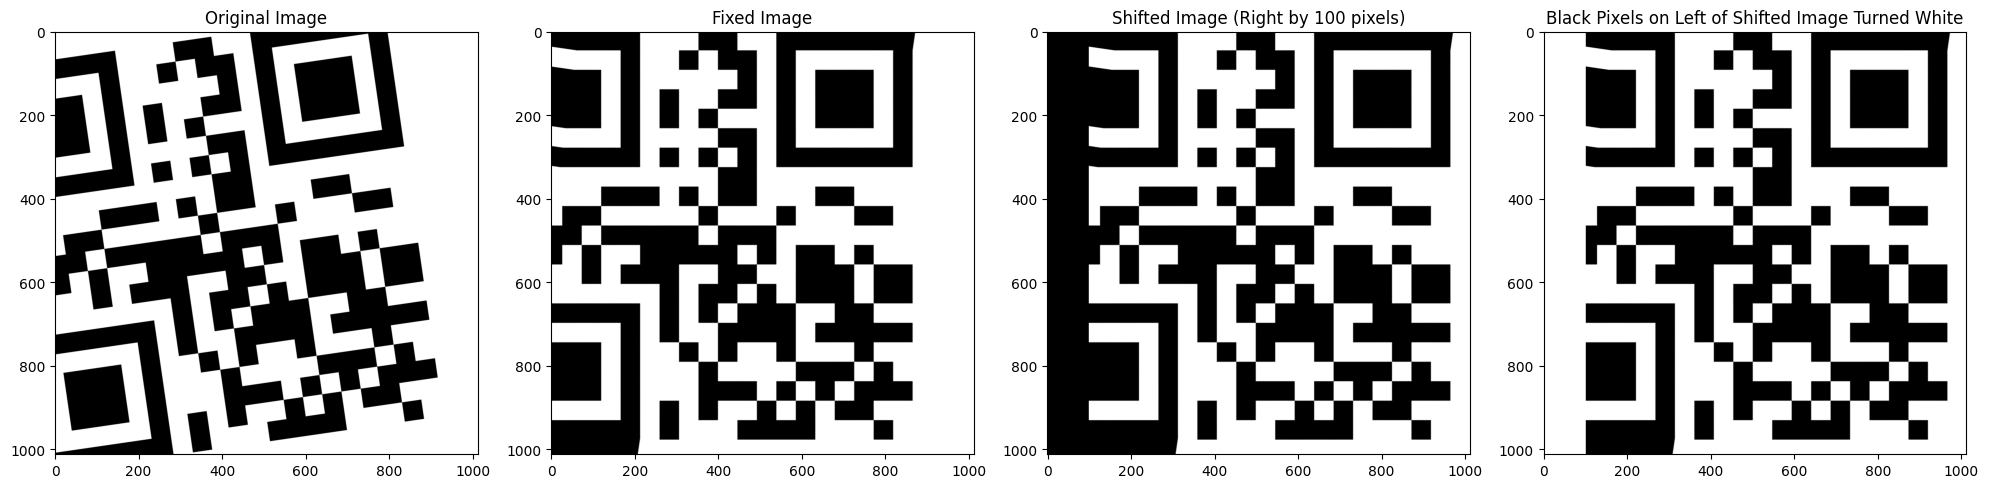

In [326]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot the original image
axes[0].imshow(images[1][0], cmap='gray')
axes[0].set_title('Original Image')

# Plot the fixed image
axes[1].imshow(fixedImages[1], cmap='gray')
axes[1].set_title('Fixed Image')

# Apply the mask to the fixed image and plot the result
shift_amount = 100
mask = np.zeros_like(fixedImages[1])
mask[:, shift_amount:] = fixedImages[1][:, :-shift_amount]
axes[2].imshow(mask, cmap='gray')
axes[2].set_title('Shifted Image (Right by 100 pixels)')

# Turn black pixels on the left side of the shifted image to white
shifted_image = mask.copy()
shifted_image[:, :shift_amount] = 255  # Set the left side to white

# Plotting the result
axes[3].imshow(shifted_image, cmap='gray')
axes[3].set_title('Black Pixels on Left of Shifted Image Turned White')


plt.tight_layout()  # Ensure tight layout
plt.show()

<hr />

<hr />

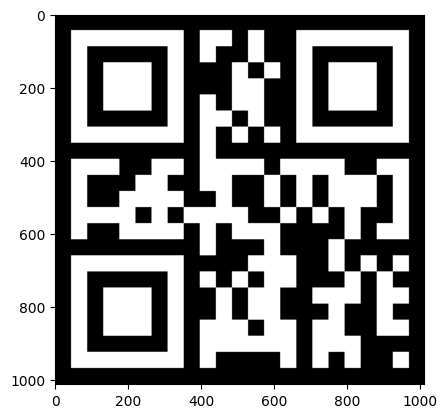

In [327]:
tc4 = cv2.imread('TC/04.png',0)

contours = findContours(tc4)

__,__,t = filterContoursV2(contours)

fixed = ut.fixFlippedFixedQr(tc4,t)

plt.imshow(fixed,cmap='gray')

<hr />

<hr />

<font style="font-size:3em" color='#121212'>Individual Solutions </font>

<font style="font-size:1.5em" color='RED'>Incomplete </font>



<font style="font-size:1em" color='Black'> Test Case 7 </font>


In [328]:
TC7 = loadImageT('TC/07.png')

TC7Fixed = drawLocatorBoxes(TC7)


fixedImages[8] = TC7Fixed

<font style="font-size:1em" color='Black'> Test Cases 6 and 14</font>


In [329]:
tc6 = loadImageT('TC/14.png')
tc6Fixed = AdjustPrespective(tc6)

tc14 = loadImageT('TC/14.png')
tc14Fixed = AdjustPrespective(tc14)


<hr />

<font style="font-size:1em" color='Black'> Test Cases 11 and 12 </font>
Located in FIle TC11&12.ipynb

<hr />

<hr />

<font style="font-size:3em" color='#121212'>Preprocessing Comparisons </font>

<font style="font-size:1.5em" color='RED'>Incomplete </font>



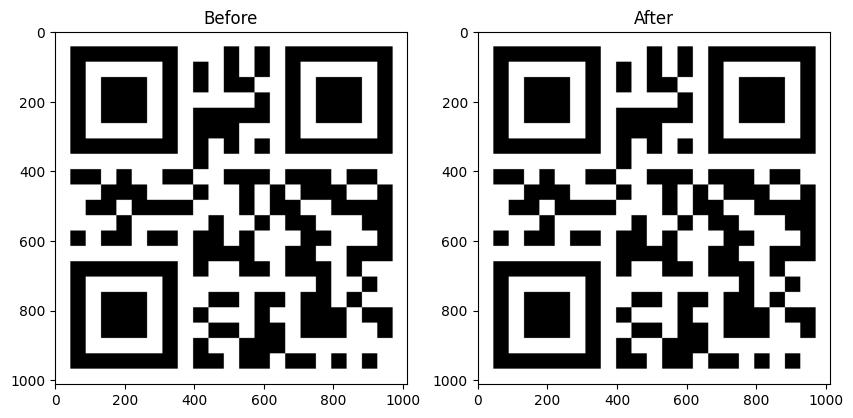

In [330]:
# TC 1

fig = plt.figure(figsize=(10, 5))



#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[0][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(fixedImages[0],cmap='gray')
ax2.set_title('After')


plt.show()

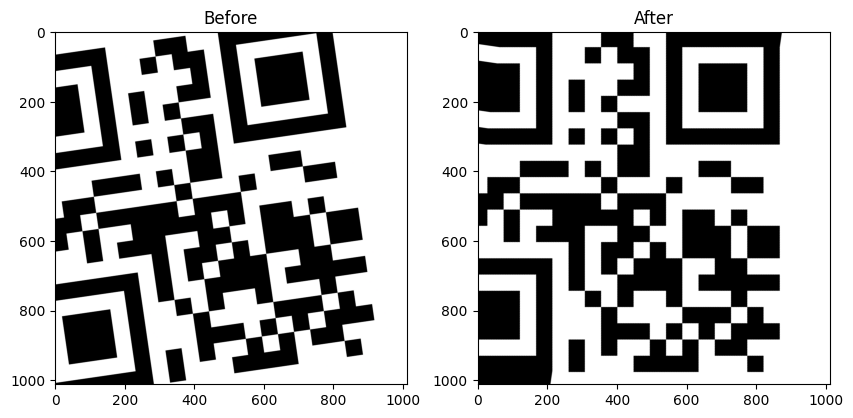

In [331]:
# TC 2

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[1][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(fixedImages[1],cmap='gray')
ax2.set_title('After')


plt.show()

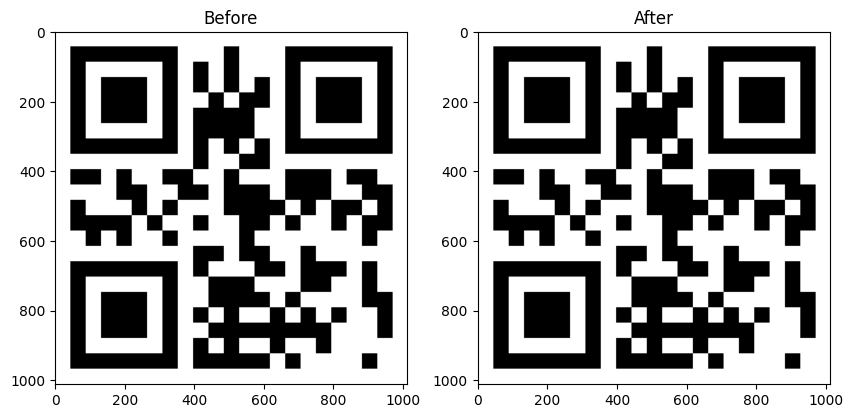

In [332]:
# TC 3

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[2][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(fixedImages[2],cmap='gray')
ax2.set_title('After')


cv2.imwrite('tc3.png',fixedImages[2])

plt.show()

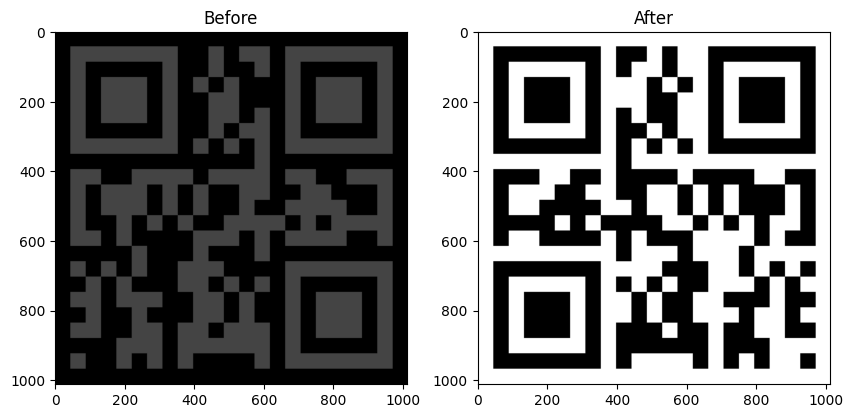

In [333]:
# TC 4 

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[3][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(fixedImages[3],cmap='gray')
ax2.set_title('After')


plt.show()

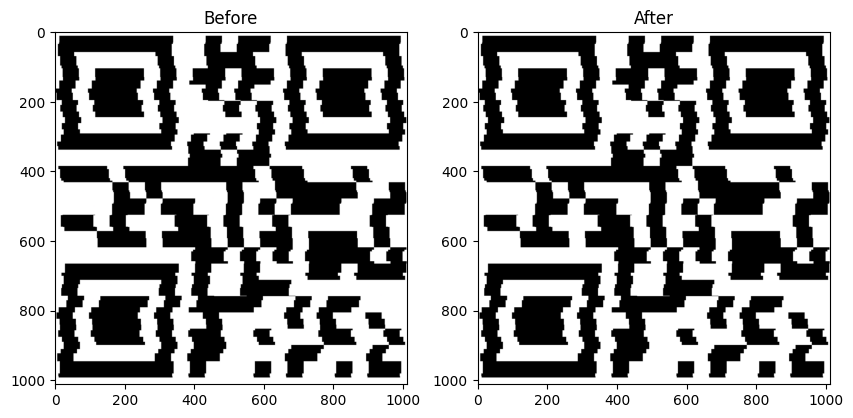

In [334]:
# TC 5

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[4][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(fixedImages[4],cmap='gray')
ax2.set_title('After')


plt.show()

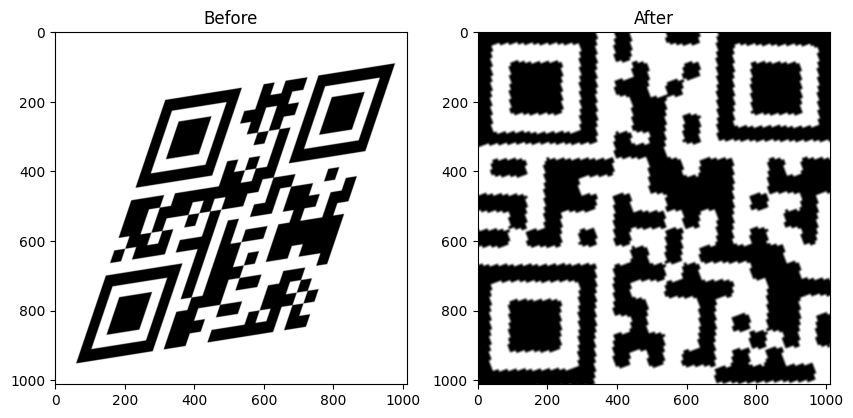

In [335]:
# TC 6

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[5][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(tc6Fixed,cmap='gray')
ax2.set_title('After')


plt.show()

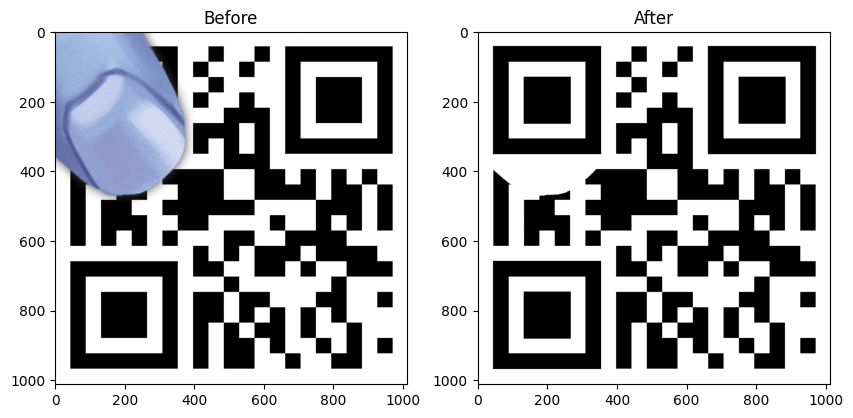

In [336]:
# TC 7

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[6][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(TC7Fixed,cmap='gray')
ax2.set_title('After')


plt.show()

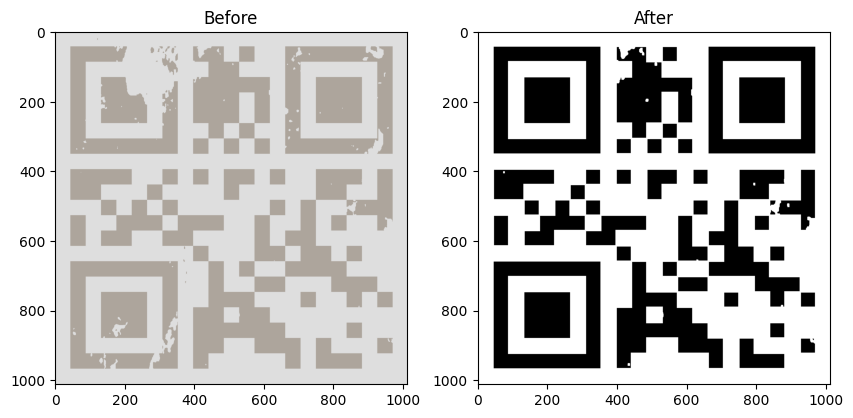

In [337]:
# TC 8

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[7][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(fixedImages[7],cmap='gray')
ax2.set_title('After')


plt.show()

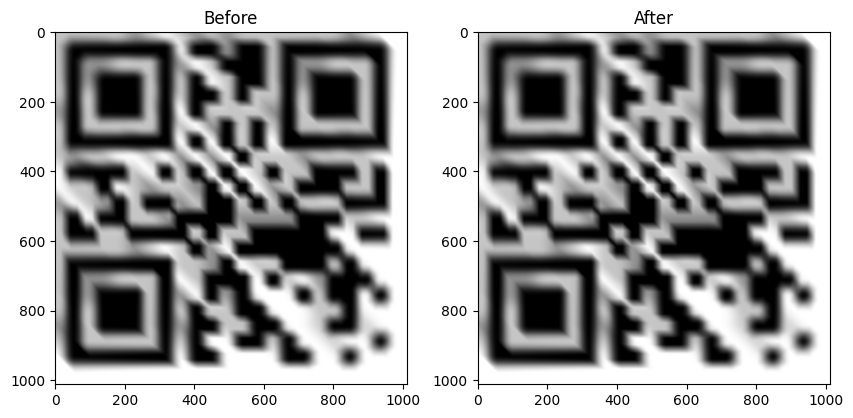

In [338]:
# TC 9

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[8][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(images[8][0],cmap='gray')
ax2.set_title('After')


plt.show()

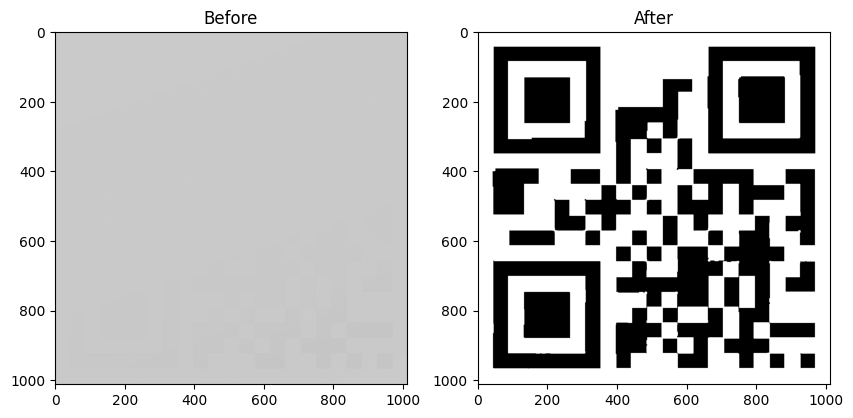

In [339]:
# TC 10

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(images[9][0],cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(fixedImages[9],cmap='gray')
ax2.set_title('After')


plt.show()

11 and 12 in their own file.
13 No Progress Yet
15 No Progress Yet
16 No Progress Yet

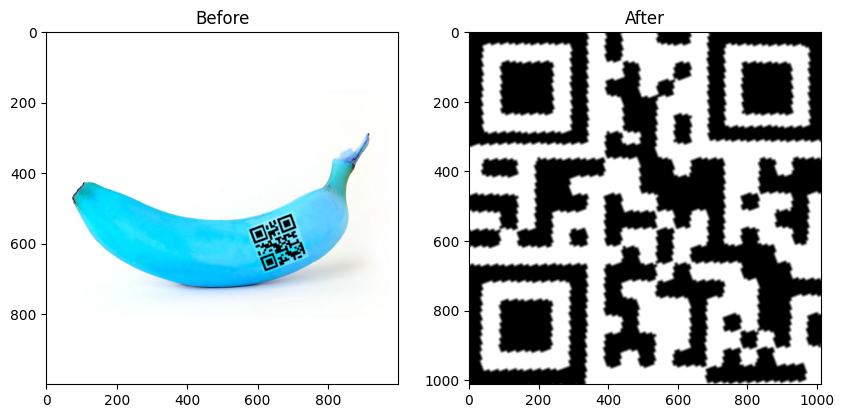

In [340]:
# TC 14

fig = plt.figure(figsize=(10, 5))

#Before
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img14,cmap='gray')
ax1.set_title('Before')

#After
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(tc14Fixed,cmap='gray')
ax2.set_title('After')


plt.show()

<font style="font-size:3em" color='#FFFFFF'>Decoder </font>

In [341]:

#1#imporing image and making it black and white // and ploting it

def Decode(img):
    fig = plt.figure(figsize=(5, 5));
    plt.xticks([], []);
    plt.yticks([], []);
    plt.title('Example QR code')
    plt.imshow(img, cmap='gray');
    print("Dimensions of the img:",img.shape)

    #2#reading queit zone // reading where is the white part that surrounds QR code and indicating the boundaries of the QR code
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1

    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                break
        if start_row != -1:
            break

    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                break
        if end_row != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
        for pixel in col:
            if pixel != 255:
                end_col = img.shape[1] - col_index
                break
        if end_col != -1:
            break

    print("boundaries of QR code are:", start_row, end_row, start_col, end_col)


    #3#taking the indicated boundaries of the QR code plotting it, removing all white space surrounding it
    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
    fig = plt.figure(figsize=(5, 5));
    plt.xticks([], []);
    plt.yticks([], []);
    fig.get_axes()[0].spines[:].set_color('red');
    fig.get_axes()[0].spines[:].set_linewidth(40);
    fig.get_axes()[0].spines[:].set_position(("outward", 20))
    plt.title('QR code without quiet zone', y = 1.15, color='red');
    plt.imshow(qr_no_quiet_zone, cmap='gray');

    # calculating dimensions of the QR code without the quiet zone (.shape get dimensions of the array)
    print("Dimensions of the QR code without QZ:",qr_no_quiet_zone.shape)


    #using this QR code version, the qr have 21 unique square in each dimension .. so we'll make grid of 21x21 cell

    grid_cells_num = 21

    #check if qr code dimensions without QZ is square , if not make it square
    newsize = max(qr_no_quiet_zone.shape[0], qr_no_quiet_zone.shape[1])
    #ensure that the new size is multiple of 21:
    newsize = grid_cells_num * np.ceil(newsize / grid_cells_num).astype(int)
    qr_no_quiet_zone = cv2.resize(qr_no_quiet_zone, (newsize, newsize))
    print("hello")


    grid_cell_size= qr_no_quiet_zone.shape[0]//grid_cells_num


    print("Dimensions of the QR code after resizing:",qr_no_quiet_zone.shape)


    #4#now we grid the QR code into small boxes using .reshape
    #grid_cells_num: number of rows and cols of the small boxes
    #grid_cell_size: size of each small box
    #.swapaxes : arrange the splitted small boxes correctly and aligned like the original QR code
    qr_cells = qr_no_quiet_zone.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )).swapaxes(1, 2)
    print(qr_cells.shape)


    #plot the QR in small boxes each box framed in red frame
    _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            col.spines[:].set_color('red')

    #5#converting each grid cell to a numeric value such that / if common color white=1/ common color black =0
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)

    print(qr_cells_numeric)


    #INFORMATION EXTRACTION
    #NOTEE: the QR code and our map have opposite ideas of what's black and what's white.
    # So, we flip the bits (change 0 to 1 and 1 to 0) to make them match the real QR code

    #6 . inspecting 8th row
    #checking first 2 bits QR to indicate the error recovery level of the QR code
    # We want row #8
    qr_cells_numeric[8]

    # The first two bits determine the error correction level
    # Level L (Low)         [11]	7%  of data bytes can be restored.
    # Level M (Medium)      [10]	15% of data bytes can be restored.
    # Level Q (Quartile)    [01]	25% of data bytes can be restored.
    # Level H (High)        [00]	30% of data bytes can be restored.
    ecl = [int(not(c)) for c in qr_cells_numeric[8, 0:2]]
    # Why "not"? Because the standard uses '1's for black and '0's for white
    #
    # "A dark module is a binary one and a light module is a binary zero."
    #  - ISO/IEC 18004:2000(E)
    #
    # In image processing, we use them the other way.. Hence the inversion
    print(ecl)

    #next 3 cells indicate mask used on the qr code
    # Dictionary of all masks and their equivalent formulae
    MASKS = {
        "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
        "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
        "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
        "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
        "100": lambda i, j: i % 2 == 0,
        "101": lambda i, j: (i + j) % 2 == 0,
        "110": lambda i, j: (i + j) % 3 == 0,
        "111": lambda i, j: j % 3 == 0,
    }

    # the three cells after the ecl cells (converted to a string)
    mask = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
    mask_str = ''.join([str(c) for c in mask])
    print(mask_str)


    # Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
    #  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)

    fec = [] #fec= Format Error Correction //list where we will collect some infor about QR
    #collect 5th and 7th cells in 8th row /and 8th column except 6th elements as it is always=1
    fec.append(qr_cells_numeric[8, 5])
    fec.append(qr_cells_numeric[8, 7])
    fec.extend(qr_cells_numeric[0:6, 8])
    fec.extend(qr_cells_numeric[7:9, 8])
    fec = [int(not(c)) for c in fec]
    print(fec)

    # So in total we have the following 15 bits of format info from our QR code
    #summary of the special settings the QR code uses to ensure it is read correctly and robustly.
    print(ecl, mask, fec)



    # Let's cross-check with our example
    _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
    for i, row in enumerate(axes):
        for j, col in enumerate(row):

            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            if (i == 8 and j <= 8) or (i <= 8 and j == 8):
                if (i != 6) and (j != 6):
                    col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                    col.spines[:].set_color('red')
                    continue
            col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)

    # However..... You need to XOR that with the "format mask": 101010000010010
    ecl[0] ^= 1
    mask[0] ^= 1
    mask[2] ^= 1
    fec[5] ^= 1
    fec[8] ^= 1

    # And now we print...
    print(ecl, mask, fec)

    # Before we proceed, let's write a function for masking to make our lives easier
    UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

    def apply_mask(data_start_i, data_start_j, direction):
        '''
        data_start_i/j represent the first cell's coords in its respective direction
        direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
        '''
        result = []
        row_offsets = []
        col_offsets = []
        if (direction in [UP, UP_ENC]):
            row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
            col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
        if (direction == DOWN):
            row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
            col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
        if (direction == CW):
            row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
            col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
        if (direction == CCW):
            row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
            col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

        for i, j in zip(row_offsets, col_offsets):
            cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
            result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

        return result[:4] if direction == UP_ENC else result

    #DATA ENCODING
    enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
    print(enc)

    len = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
    print(len)

    data_starting_indices = [
        [grid_cells_num-7, grid_cells_num-1, UP],
        [grid_cells_num-11, grid_cells_num-1, CCW],
        [grid_cells_num-10, grid_cells_num-3, DOWN],
        [grid_cells_num-6, grid_cells_num-3, DOWN],
        [grid_cells_num-2, grid_cells_num-3, CW],
        [grid_cells_num-3, grid_cells_num-5, UP],
        [grid_cells_num-7, grid_cells_num-5, UP],
        [grid_cells_num-11, grid_cells_num-5, CCW],
        [grid_cells_num-10, grid_cells_num-7, DOWN],
        [grid_cells_num-6, grid_cells_num-7, DOWN],
        [grid_cells_num-2, grid_cells_num-7, CW],
        [grid_cells_num-3, grid_cells_num-9, UP],
        [grid_cells_num-7, grid_cells_num-9, UP],
        [grid_cells_num-11, grid_cells_num-9, UP],
        [grid_cells_num-16, grid_cells_num-9, UP],
        [grid_cells_num-20, grid_cells_num-9, CCW],
        [grid_cells_num-19, grid_cells_num-11, DOWN],
        [grid_cells_num-14, grid_cells_num-11, DOWN],
        [grid_cells_num-10, grid_cells_num-11, DOWN],
        [grid_cells_num-6, grid_cells_num-11, DOWN],
        # Hmm..? I actually don't know how to proceed now lol
    ]

    ans = ''
    for a, b, d in data_starting_indices:
        bits = apply_mask(a, b, d)
        bit_string = ''.join([str(bit) for bit in bits])
        if bit_string[:4] == "0000":
            print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
            break
        ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
        print(f'{bit_string} = {ans[-1]}')

    print(f'\nDecoded string: {ans}')

In [342]:
#Decode(img01T)